### Contexto
Desenvolver um modelo para prever transações fraudulentas para uma empresa financeira. Os dados do caso estão disponíveis em formato CSV com 6362620 linhas e 10 colunas.

### Dicionário de Dados

* step → Unidade de tempo simulada. Cada step corresponde a 1 hora no mundo real. O dataset cobre 744 steps (30 dias de simulação).
* type → Tipo de transação: CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER.
* amount → Valor da transação (moeda local).
* nameOrig → Identificação do cliente que iniciou a transação.
* oldbalanceOrg → Saldo inicial do cliente antes da transação.
* newbalanceOrig → Saldo do cliente após a transação.
* nameDest → Identificação do cliente que recebeu a transação.
* oldbalanceDest → Saldo inicial do recebedor antes da transação.  
 Obs: para clientes que começam com “M” (Merchants) essa informação não está disponível.
* newbalanceDest → Saldo do recebedor após a transação.  
Obs: também ausente para clientes que começam com “M” (Merchants).
* isFraud → Transações realizadas por agentes fraudulentos durante a simulação.  
O comportamento fraudulento consiste em assumir o controle de contas e esvaziar fundos transferindo para outra conta e sacando em seguida.
* isFlaggedFraud → Flag do sistema que tenta identificar transações ilegais.  
Neste dataset, uma transação é sinalizada se for uma transferência maior que 200.000 em valor único.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
df = pd.read_parquet("../data/interim/Fraud_sample.parquet")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,259,CASH_IN,496707.37,C1373083589,4952451.30,5449158.67,C1340202832,987166.62,449602.71,0,0
1,201,CASH_IN,105439.58,C1205141105,79395.00,184834.58,C2035225037,977274.66,871835.08,0,0
2,326,CASH_IN,255578.06,C1228913525,9165963.42,9421541.48,C1025341440,471418.15,215840.09,0,0
3,371,CASH_IN,4122.61,C507172116,8167117.87,8171240.48,C285883107,1023353.23,1019230.62,0,0
4,10,CASH_IN,195440.90,C631715983,20530.00,215970.90,C1198620089,0.00,0.00,0,0


In [3]:
# Visão geral do dataframe
df.info()
print(30*'-')
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499999 entries, 0 to 499998
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            499999 non-null  int64  
 1   type            499999 non-null  object 
 2   amount          499999 non-null  float64
 3   nameOrig        499999 non-null  object 
 4   oldbalanceOrg   499999 non-null  float64
 5   newbalanceOrig  499999 non-null  float64
 6   nameDest        499999 non-null  object 
 7   oldbalanceDest  499999 non-null  float64
 8   newbalanceDest  499999 non-null  float64
 9   isFraud         499999 non-null  int64  
 10  isFlaggedFraud  499999 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 42.0+ MB
------------------------------


,count,mean,std,min,25%,50%,75%,max
step,499999.0,2.430917e+02,1.418118e+02,1.0,156.00,239.00,334.000,7.430000e+02
amount,499999.0,1.812398e+05,6.286520e+05,0.0,13354.37,75038.82,209137.645,7.117248e+07
oldbalanceOrg,499999.0,8.295157e+05,2.875832e+06,0.0,0.00,14237.25,107172.000,3.741827e+07
newbalanceOrig,499999.0,8.507560e+05,2.911887e+06,0.0,0.00,0.00,144568.895,3.494676e+07
oldbalanceDest,499999.0,1.096916e+06,3.367976e+06,0.0,0.00,133238.12,942149.185,3.278521e+08
newbalanceDest,499999.0,1.224066e+06,3.670293e+06,0.0,0.00,215174.67,1111137.305,3.279630e+08
isFraud,499999.0,1.290003e-03,3.589347e-02,0.0,0.00,0.00,0.000,1.000000e+00
isFlaggedFraud,499999.0,2.000004e-06,1.414215e-03,0.0,0.00,0.00,0.000,1.000000e+00


In [4]:
# Checando valores ausentes
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

#### Observações

* O dataframe possuí um total de 8 colunas númericas e 3 colunas categóricas.
* 3 das colunas numéricas são do tipo int e 5 são do tipo float.
* O dataframe não possuí valores ausentes.

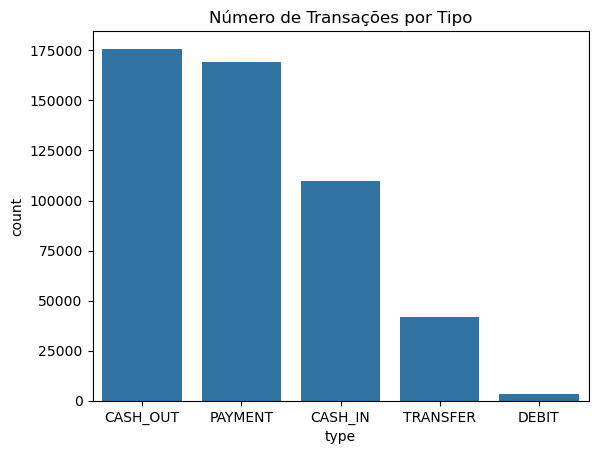

In [5]:
# Distribuição dos dados por tipo de transação
order = df['type'].value_counts().index
sns.countplot(x = 'type', data = df, order = order )
plt.title('Número de Transações por Tipo')
plt.show()

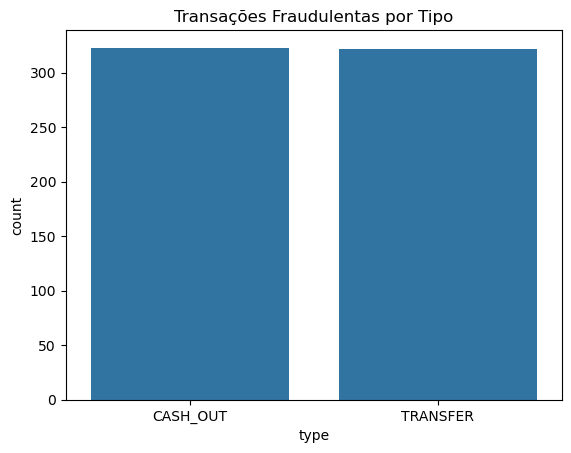

In [6]:
sns.countplot(x = 'type', data = df[df['isFraud'] == 1])
plt.title('Transações Fraudulentas por Tipo')
plt.show()

#### Observações

* Dos tipos de transações, cash_out, payment e cash_in são os mais predominantes.
* Transações fraudulentas ocorrem apenas nos tipos transfer e cash_out.
* Há pouquíssimas transações fraudulentas em relação às transações legítimas.

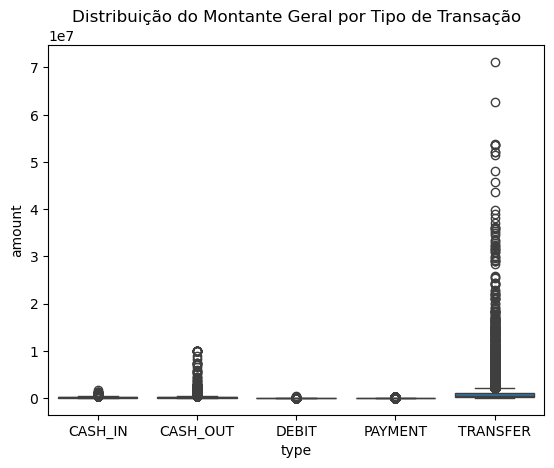

In [7]:
sns.boxplot(x='type', y='amount', data=df)
plt.title('Distribuição do Montante Geral por Tipo de Transação')
plt.show()

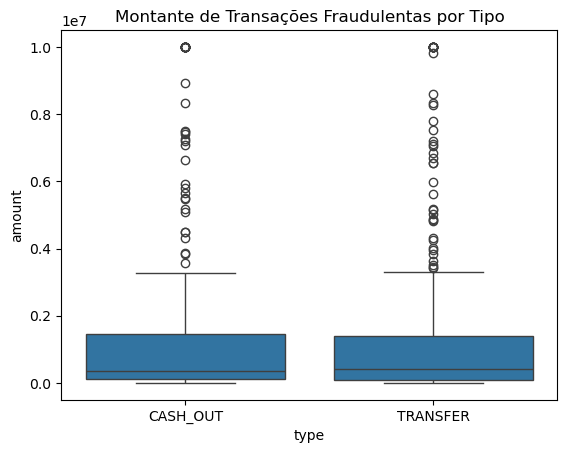

In [8]:
sns.boxplot(x='type', y='amount', data=df[df['isFraud']==1])
plt.title('Montante de Transações Fraudulentas por Tipo')
plt.show()

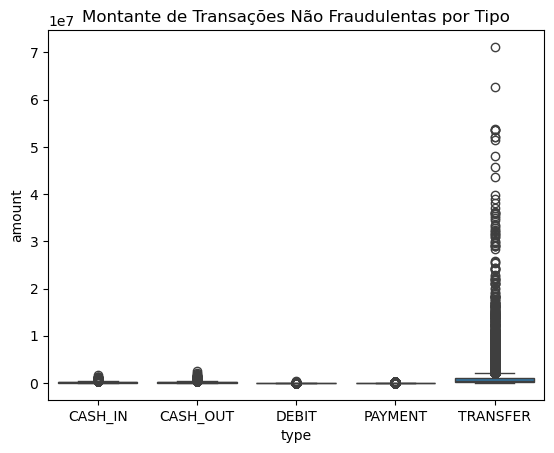

In [9]:
sns.boxplot(x='type', y='amount', data=df[df['isFraud']==0])
plt.title('Montante de Transações Não Fraudulentas por Tipo')
plt.show()

#### Observações

* Transações com valores muito altos (outliers) são comuns em todas as categorias. A maioria desses valores extremos, no entanto, é de transações legítimas, e não fraudulentas.
* Embora as fraudes de alto valor sejam as mais notáveis, a maioria das transações fraudulentas, tanto CASH_OUT quanto TRANSFER, tem um valor relativamente baixo.


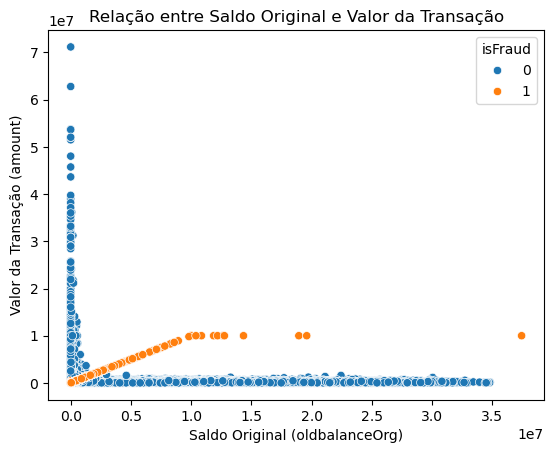

In [10]:
sns.scatterplot(x='oldbalanceOrg', y='amount', hue='isFraud', data=df)
plt.title('Relação entre Saldo Original e Valor da Transação')
plt.xlabel('Saldo Original (oldbalanceOrg)')
plt.ylabel('Valor da Transação (amount)')
plt.show()

#### Observações

* Grande parte das transações fraudulentas seguem o comportamento de esvaziar o saldo da conta o transferindo pra outro como visto no dicionário de dados.
* O valor das transferências fraudulentas chega próximo à 10 milhões mesmo com o saldo superior a isso. O que pode indicar transferências parceladas para evitar ser sinalizado.

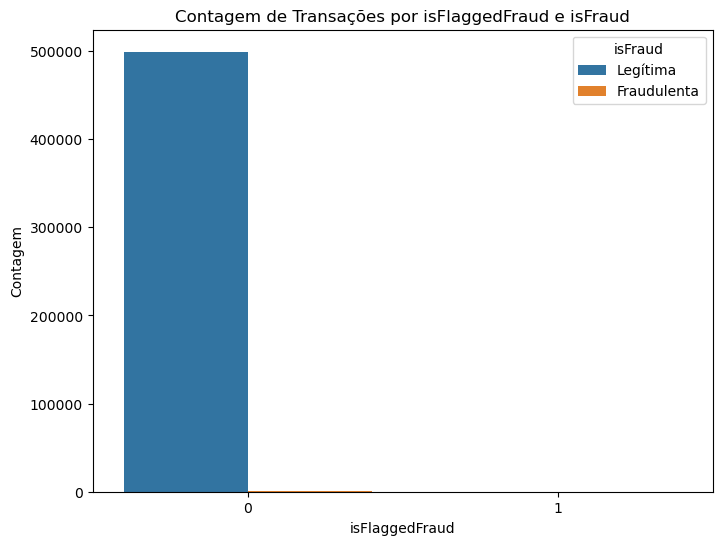

Número de fraudes sinalizadas pelo sistema: 1
Número de fraudes não sinalizadas pelo sistema: 644
Porcentagem de fraudes sinalizadas: 0.16%
Porcentagem de fraudes não sinalizadas: 99.84%


In [11]:
# Gráfico de contagem para visualizar a relação entre isFraud e isFlaggedFraud
plt.figure(figsize=(8, 6))
sns.countplot(x='isFlaggedFraud', hue='isFraud', data=df)
plt.title('Contagem de Transações por isFlaggedFraud e isFraud')
plt.xlabel('isFlaggedFraud')
plt.ylabel('Contagem')
plt.legend(title='isFraud', labels=['Legítima', 'Fraudulenta'])
plt.show()

fraud_flagged = df[(df['isFraud'] == 1) & (df['isFlaggedFraud'] == 1)]
fraud_not_flagged = df[(df['isFraud'] == 1) & (df['isFlaggedFraud'] == 0)]

total_frauds = len(df[df['isFraud'] == 1])

print(f"Número de fraudes sinalizadas pelo sistema: {len(fraud_flagged)}")
print(f"Número de fraudes não sinalizadas pelo sistema: {len(fraud_not_flagged)}")
print(f"Porcentagem de fraudes sinalizadas: {(len(fraud_flagged) / total_frauds) * 100:.2f}%")
print(f"Porcentagem de fraudes não sinalizadas: {(len(fraud_not_flagged) / total_frauds) * 100:.2f}%")


#### Observações 

* A varivel isFlaggedFraud se demonstrou ineficiênte para a sinalização de transações fraudulentas
* esse número idica que a cada 1000 transações fraudulentas o sistema identifica 1 ou 2 enquanto os outros passam despercebidos

In [12]:
df_transfer = df[df['type'] == 'TRANSFER'].copy()

df_transfer.sort_values(by=['nameOrig', 'step'], inplace=True)

df_transfer['balance_diff'] = df_transfer.groupby('nameOrig')['oldbalanceOrg'].diff()
df_transfer['amount_diff'] = df_transfer.groupby('nameOrig')['amount'].diff()

sequencia_suspeita = df_transfer[
    (df_transfer['nameOrig'].duplicated(keep=False)) &
    (df_transfer['isFraud'] == 1)
]

print("Sequências de transferências fraudulentas por cliente:")
print(sequencia_suspeita[['step', 'nameOrig', 'oldbalanceOrg', 'amount', 'isFraud', 'balance_diff', 'amount_diff']])

Sequências de transferências fraudulentas por cliente:
Empty DataFrame
Columns: [step, nameOrig, oldbalanceOrg, amount, isFraud, balance_diff, amount_diff]
Index: []


#### Observações

* Não foi sinalizado que caso de fraudes do mesmo cliente